In [580]:
import numpy as np
import matplotlib.pyplot as plt
from utils import *
%load_ext autoreload
%autoreload 2
%matplotlib inline
plt.rcParams['figure.figsize'] = (10,8)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Experiment setup

In [426]:
task = TaskSetup(2, 40, 8)

Text(0.5, 1.0, 'true sources field')

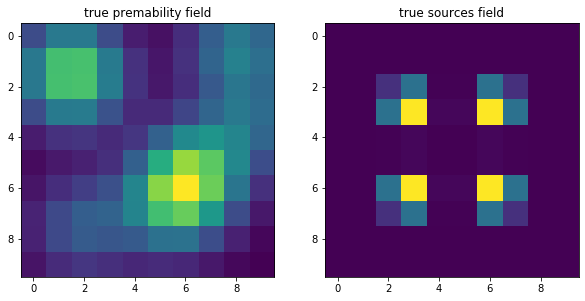

In [425]:
_, (ax1, ax2) = plt.subplots(1, 2)
ret = ax1.imshow(task.K); ax1.set_title('true premability field')
ax2.imshow(task.Q); ax2.set_title('true sources field')

In [412]:
task.eval_u_x(np.random.rand(len(task.x)), np.random.rand(*task.K.shape)).shape

(40, 40)

In [419]:
from scipy.optimize import minimize

def opt(u):
#     print('here ', opt.i)
#     opt.i += 1
    u = u.reshape(*task.K.shape)
    res = np.linalg.norm(task.eval_u_x(task.x, u))
    return res

# opt.i = 0

In [422]:
res = minimize(opt, np.random.rand(np.prod(task.K.shape)), options={'maxiter': 1000, 'disp': True})
res

         Current function value: 0.056354
         Iterations: 1000
         Function evaluations: 1603602
         Gradient evaluations: 1001


      fun: 0.05635396505082187
 hess_inv: array([[115.95377677,  43.66586996,   2.86655047, ...,  88.56076755,
          2.6200385 , -94.36878596],
       [ 43.66586996,  18.39183735,   2.42420345, ...,  34.07384659,
         -4.48770447, -46.06575686],
       [  2.86655047,   2.42420345,   4.00326161, ...,   3.98062018,
        -11.35998517, -25.80623969],
       ...,
       [ 88.56076755,  34.07384659,   3.98062018, ..., 115.21758275,
         52.72571053, -57.03174485],
       [  2.6200385 ,  -4.48770447, -11.35998517, ...,  52.72571053,
        137.39214959, 138.68101782],
       [-94.36878596, -46.06575686, -25.80623969, ..., -57.03174485,
        138.68101782, 298.44288139]])
      jac: array([ 0.00044638,  0.00071003, -0.00016379, ...,  0.00025414,
        0.00044609, -0.0003708 ])
  message: 'Maximum number of iterations has been exceeded.'
     nfev: 1603602
      nit: 1000
     njev: 1001
   status: 1
  success: False
        x: array([11.79778428,  3.76959217, -1.72338452, .

In [ ]:
def normal_sampler(x, n_discr, sigma=.1):
    ret = np.random.normal(x, np.diag([sigma]*len(x)))
    return np.array(ret)

In [646]:
def normal_sampler(x, sigma=.1):
    return np.random.multivariate_normal(x, np.diag([sigma]*len(x)))

def metropolis_step(x, pi, q):
    new_x = q(x)
    alpha = min(1, pi(new_ind)/pi(old_ind))
    if np.random.rand() < alpha:
        return new_x, True
    else:
        return new_x, False
    
q = partial(normal_sampler, sigma=.1)

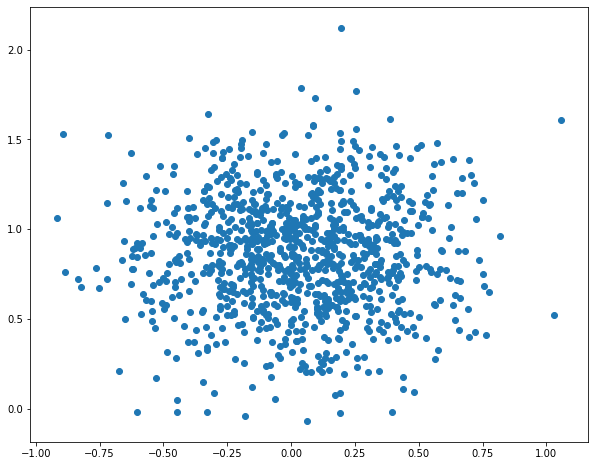

In [647]:
x = np.random.rand(2)
points = []
for _ in range(1000):
    points.append(normal_sampler(x))
points = np.array(points)
plt.scatter(points[:,0], points[:,1])

# Basis orthogonalization

In [277]:
n_vec = 3
n_dim = 5
X = list(np.random.rand(n_vec, n_dim))
q = orthonormal(X) 
assert np.allclose(np.linalg.norm(q, axis=1), np.ones(n_vec))
assert np.allclose(np.diag(q @ q.T), np.ones(n_vec))
# print(np.linalg.norm(q, axis=1), np.diag(q @ q.T))

# Metropolis–Hastings algorithm

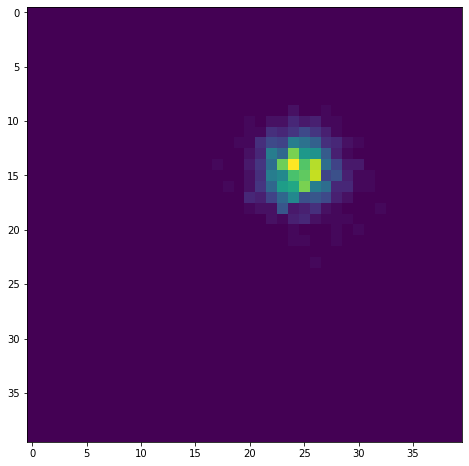

In [385]:
from scipy.stats import norm
from functools import partial

def normal_sampler(x, n_discr, sigma=.1):
    ret = []
    for ind in x:
        new_ind = norm.ppf(np.random.random(1), loc=ind, scale=sigma*n_discr).astype(int)   
        ret.append(np.clip(new_ind[0], 0, n_discr-1))
    return np.array(ret)
    
if task.n_dim == 2:
    X = np.zeros_like(task.K)
    x = np.array([15, 25])
    f = partial(normal_sampler, n_discr=task.n_discr, sigma=0.05)

    for _ in range(1000):
        x_new = f(x)
        ind1, ind2 = x_new
        X[ind1, ind2] += 1

    plt.imshow(X)

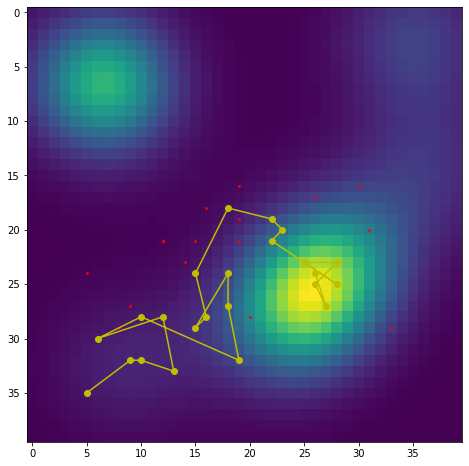

23 17


KeyboardInterrupt: 

In [399]:
from IPython.display import clear_output
from time import sleep

def metropolis_step(x, pi, q):
    """
    x: previous x (expected to be array of indexes)
    pi: pi(r), estimated distribution
    q: q(), sampling function, assumed to be symmetric
    
    returns: new_x (array of indexes), bool value (True if accepted)
    """
    new_x = q(x)
    old_ind = tuple(((k) for k in x))
    new_ind = tuple(((k) for k in new_x))
    alpha = min(1, pi[new_ind]/pi[old_ind])
#     print(alpha)
    if np.random.rand() < alpha:
        return new_x, True
    else:
        return new_x, False

if task.n_dim == 2:
    pi = task.K**2 
    x = np.array([35, 5])
    accepted = [x]
    rejected = []
    for _ in range(100):
        f = partial(normal_sampler, n_discr=task.n_discr, sigma=0.1)
        x_new, res = metropolis_step(x, pi, f)
#         x_new, res = f(x), True
        if res:
            accepted.append(x_new)
            x = x_new
        else:
            rejected.append(x_new)
            
        plt.imshow(pi)
        if len(accepted) > 2:
            accepted_ = np.array(accepted)
            
            plt.plot(accepted_[:,1], accepted_[:,0], 'yo-')
#             plt.plot(accepted_[:,1], accepted_[:,0], 'y')
        if len(rejected) > 2:
            rejected_ = np.array(rejected)
            plt.scatter(rejected_[:,1], rejected_[:,0], color='r', s=3)
        clear_output()
        plt.show()
        print(len(accepted), len(rejected))
        sleep(1)

In [402]:
np.gradient(np.random.rand(3, 3, 3))[0].shape

(3, 3, 3)

# dummy $u_0$

In [588]:
task = TaskSetup(2, 10, 9)

In [612]:
G = task.G
L = task.L
x = np.random.rand(task.n_p)
k = task.eval_perm_field(x).flatten()
K = np.diag(k)
q = task.Q.flatten()

B1, B2 = boundary_matrices(task.n_discr)
k_d = double_vec(k)
K_d = np.diag(k_d)
B1_ = B1 @ K_d @ G

In [613]:
B1.shape, K_d.shape, G.shape

((36, 200), (200, 200), (200, 100))

In [614]:
np.diag(k_d).shape

(200, 200)

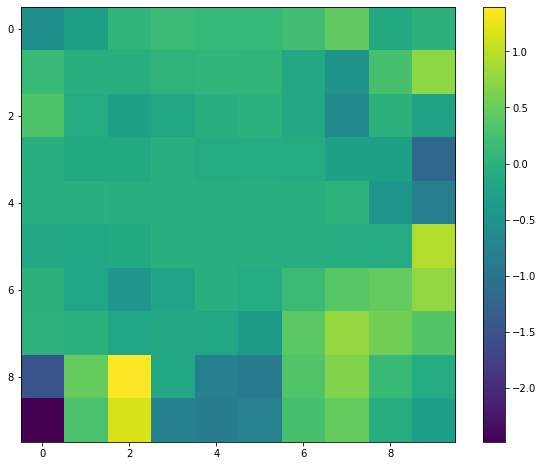

In [633]:
A = (np.dot(G.T @ G, k) + K @ L)
u = np.linalg.solve(A, -q)
# A = np.vstack([(np.dot(G.T @ G, k) + K @ L), B1_, B2])
# length = B1.shape[0] + 1
# b = np.hstack([q, np.zeros(length)])
# u, res, _, _ = np.linalg.lstsq(A, -b)


grad_u = (G @ u).reshape(100, 2)
grad_k = (G @ k).reshape(100, 2)
term1 = np.sum(grad_u*grad_k, axis=1)

term2 = K @ (L @ u)

plt.imshow((term1 + term2 + q).reshape(10, 10))
plt.colorbar()

In [581]:
B1, B2 = boundary_matrices(10)

In [583]:
B1.shapeB1.shape

(36, 200)

In [578]:
(B @ G @ u).shape
B @ G @ u

array([ 7.25312006e-01,  1.58432444e-07, -1.84346381e-01,  1.72035290e-01,
        6.34122093e-01,  6.34122093e-01,  1.72035290e-01, -1.84346381e-01,
        1.58432443e-07,  7.25312006e-01, -1.58432442e-07, -1.58432443e-07,
        1.84346381e-01,  1.84346381e-01, -1.72035290e-01, -1.72035290e-01,
       -6.34122093e-01, -6.34122093e-01, -6.34122093e-01, -6.34122093e-01,
       -1.72035290e-01, -1.72035290e-01,  1.84346381e-01,  1.84346381e-01,
       -1.58432443e-07, -1.58432444e-07,  7.25312006e-01,  1.58432443e-07,
       -1.84346381e-01,  1.72035290e-01,  6.34122093e-01,  6.34122093e-01,
        1.72035290e-01, -1.84346381e-01,  1.58432442e-07,  7.25312006e-01])